In [1]:
%pip install numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\matej\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from random import random
from scipy.spatial import ConvexHull
from matplotlib import path
import time
import math

import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def isCollisionFreeVertex(obstacles, xy):
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
#             print 'collision'
            return collFree

    return collFree

In [4]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        p = (1-t[i])*closest_vert + t[i]*xy # calculate configuration
        collFree = isCollisionFreeVertex(obstacles, p)
        if collFree == False: return False

    return collFree

In [5]:
def draw_map(obstacles, color):
    # Obstacles. An obstacle is represented as a convex hull of a number of points.
    # First row is x, second is y (position of vertices)

    # Bounds on world
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]

    # Draw obstacles
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch( Polygon(obstacles[k], color=color))
        #ax.add_patch(patch)

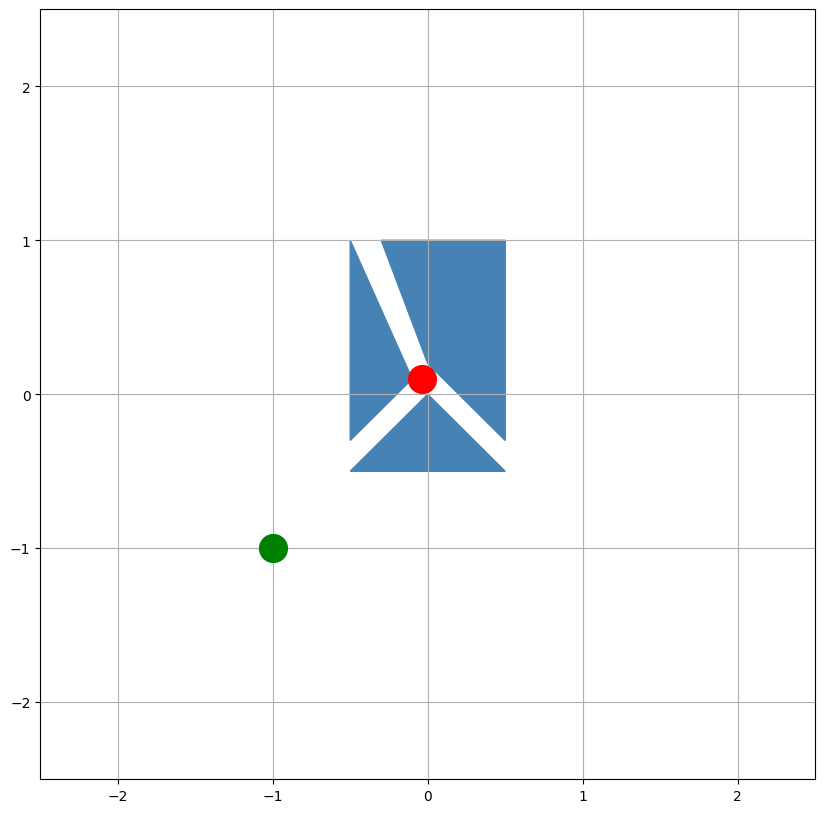

In [6]:
obstacles = [
              np.array([[0, -0.5], [0.5, -0.5], [0, 0], [-0.5, -0.5]]),
              np.array([[0, 0.2], [0.5, -0.3], [0.5, 0.2], [0.5, 1], [-0.3, 1]]),
              np.array([[-0.5, -0.3], [-0.5, 1], [-0.1, 0.1]])
            ]
draw_map(obstacles, 'steelblue')

# Start and goal positions
xy_start = np.array([-0.04, 0.1]); plt.plot(xy_start[0],xy_start[1],'ro', markersize=20)
xy_goal =  np.array([-1.0, -1.0]);  plt.plot(xy_goal[0], xy_goal[1], 'go',markersize=20)

In [7]:
obstacles

[array([[ 0. , -0.5],
        [ 0.5, -0.5],
        [ 0. ,  0. ],
        [-0.5, -0.5]]),
 array([[ 0. ,  0.2],
        [ 0.5, -0.3],
        [ 0.5,  0.2],
        [ 0.5,  1. ],
        [-0.3,  1. ]]),
 array([[-0.5, -0.3],
        [-0.5,  1. ],
        [-0.1,  0.1]])]

In [8]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.i     = 0
        self.iPrev = 0

In [9]:
def closestNode(rrt, p):
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0])**2 + (p[1] - node.p[1])**2) )
    distance = np.array(distance)

    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

Reached the goal after 0.02 seconds:
Number of iterations passed: 9 / 50000
RRT length:  8
Constructing the path...
Reached RRT start node
Reached the goal after 0.04 seconds:
Number of iterations passed: 18 / 50000
RRT length:  16
Constructing the path...
Reached RRT start node
Reached the goal after 0.31 seconds:
Number of iterations passed: 250 / 50000
RRT length:  135
Constructing the path...
Reached RRT start node
Reached the goal after 0.09 seconds:
Number of iterations passed: 63 / 50000
RRT length:  32
Constructing the path...
Reached RRT start node
Reached the goal after 0.09 seconds:
Number of iterations passed: 46 / 50000
RRT length:  32
Constructing the path...
Reached RRT start node
Reached the goal after 0.10 seconds:
Number of iterations passed: 64 / 50000
RRT length:  41
Constructing the path...
Reached RRT start node
Reached the goal after 0.08 seconds:
Number of iterations passed: 52 / 50000
RRT length:  33
Constructing the path...
Reached RRT start node
Reached the g

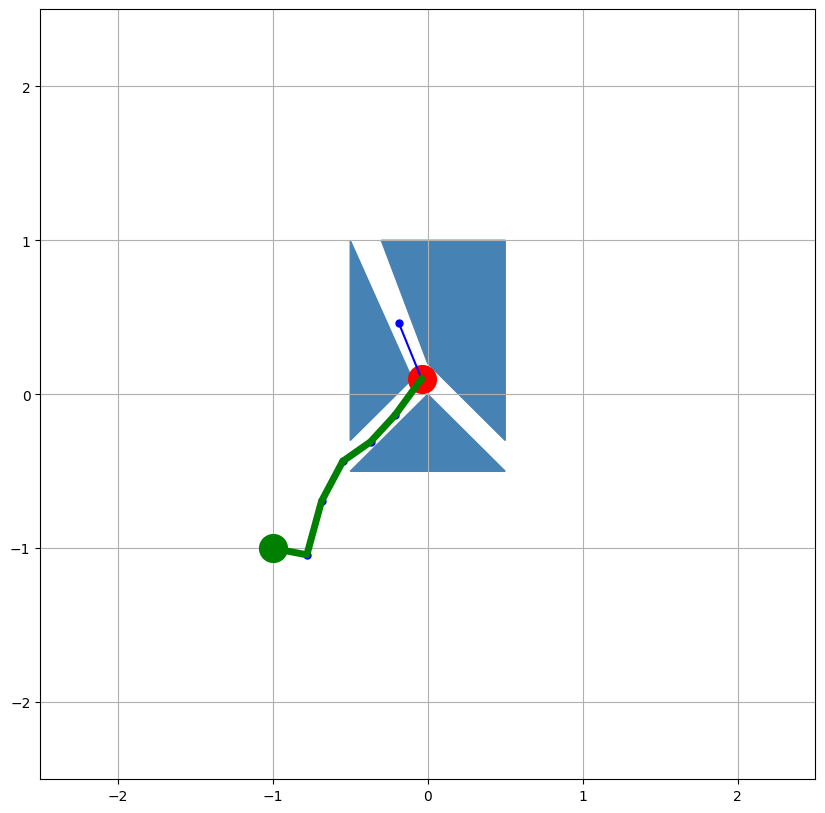

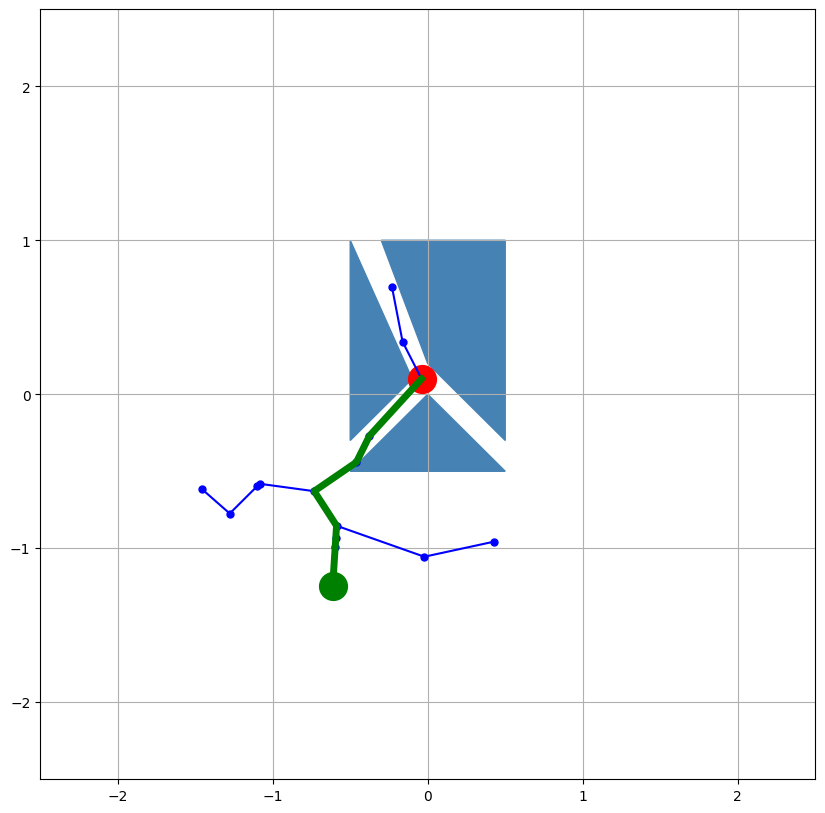

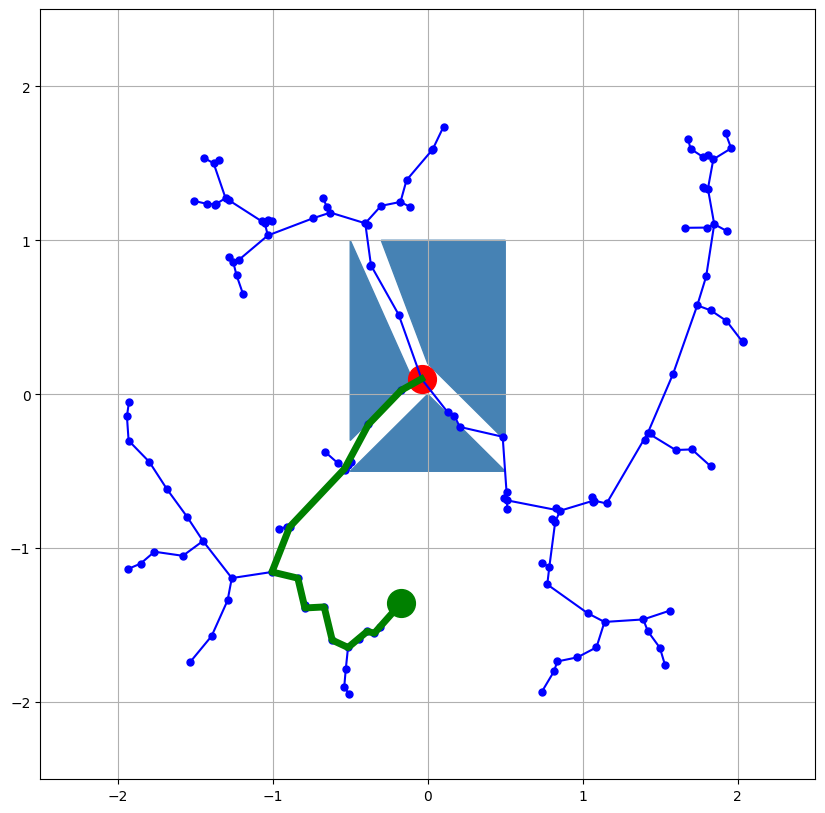

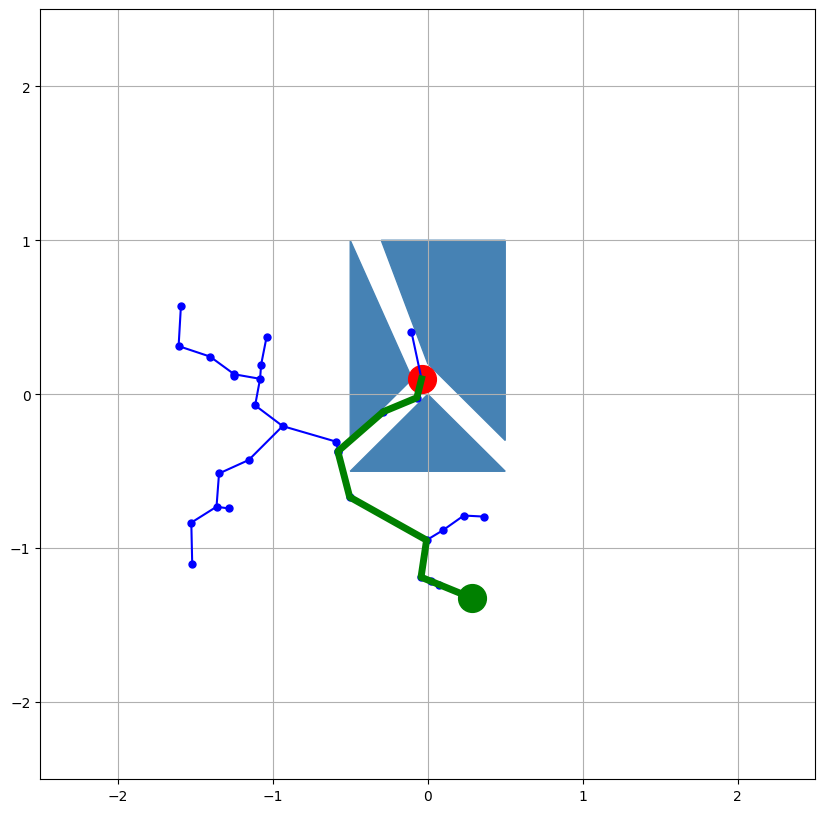

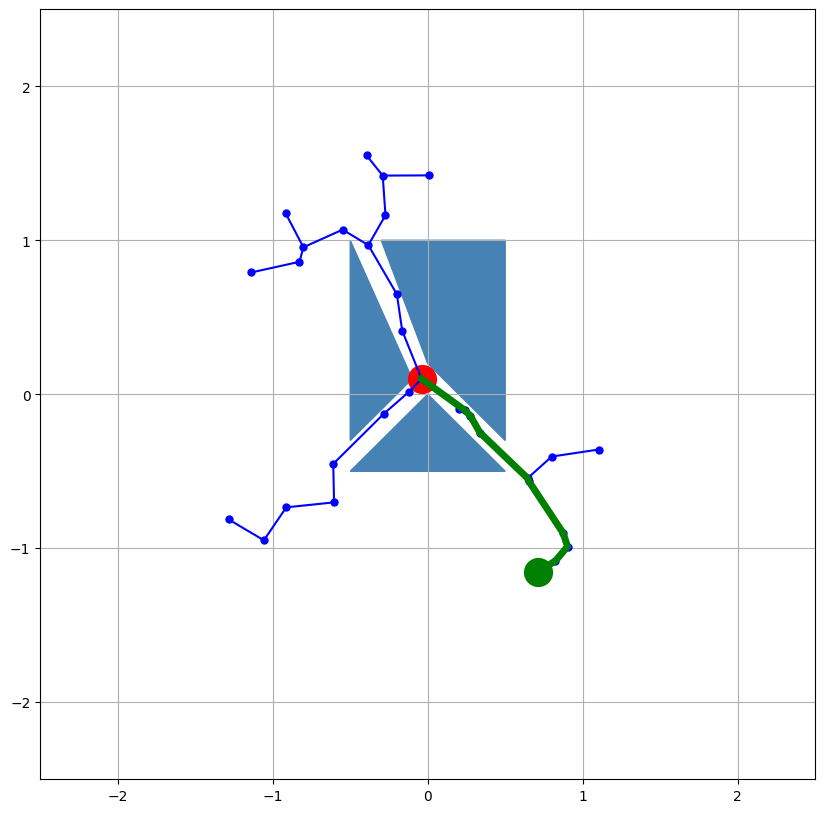

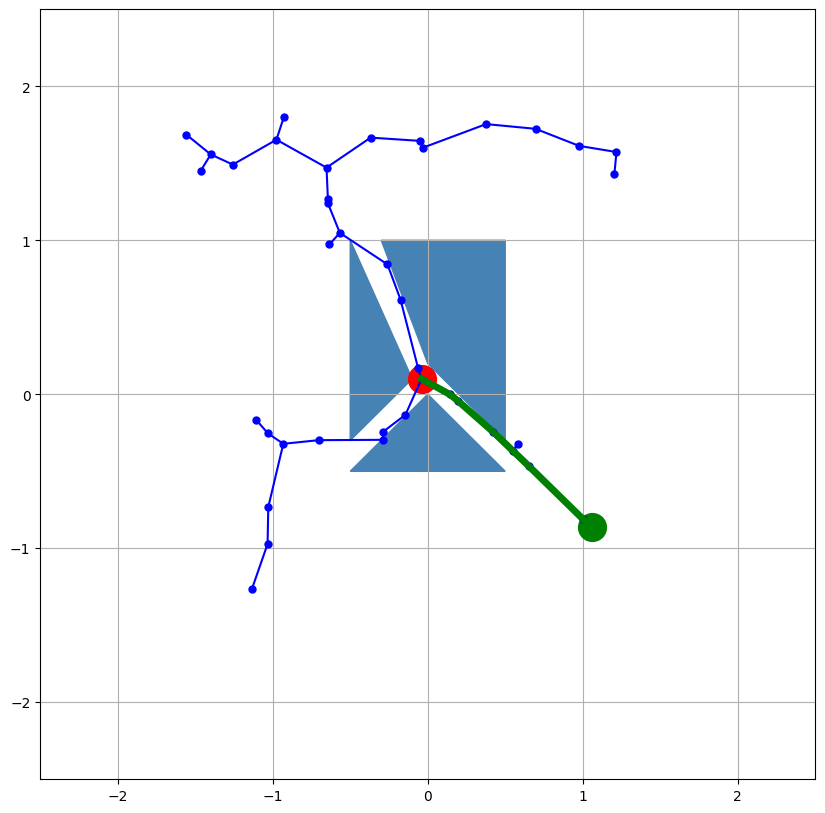

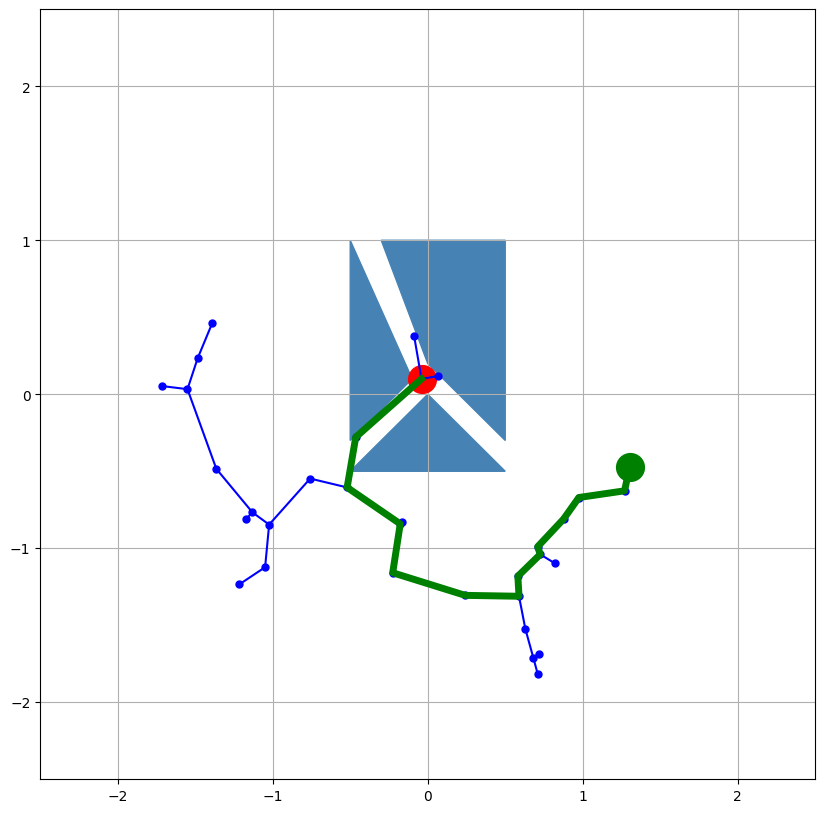

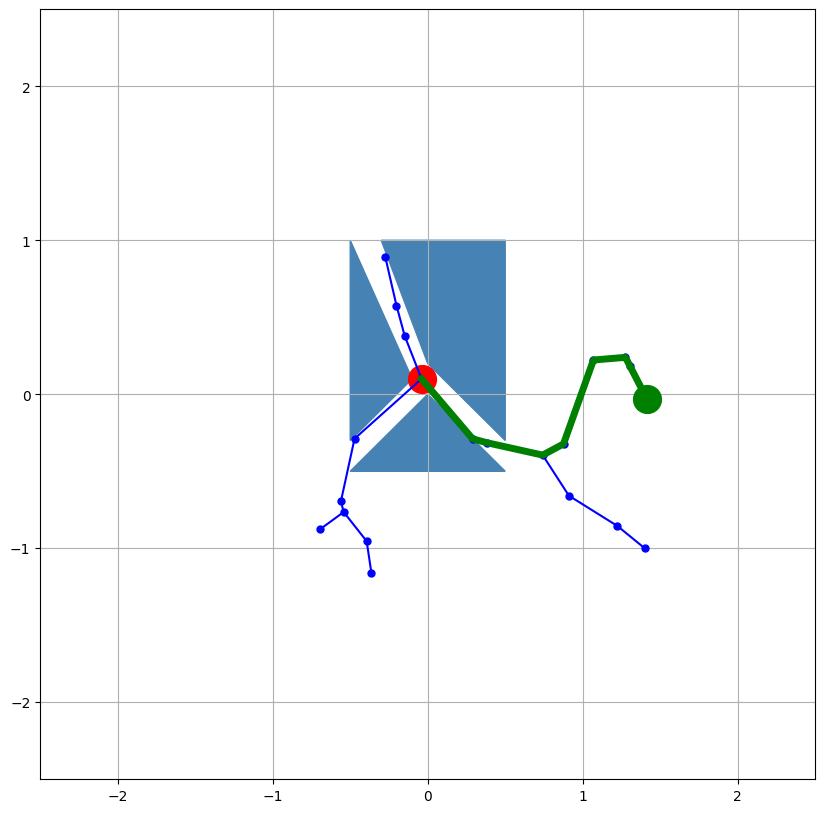

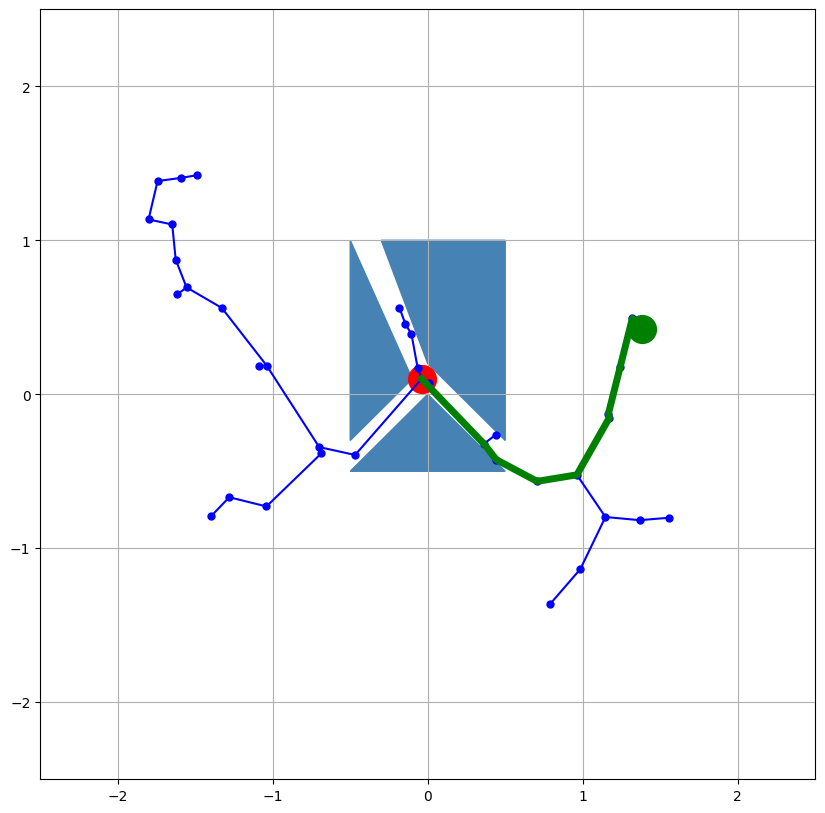

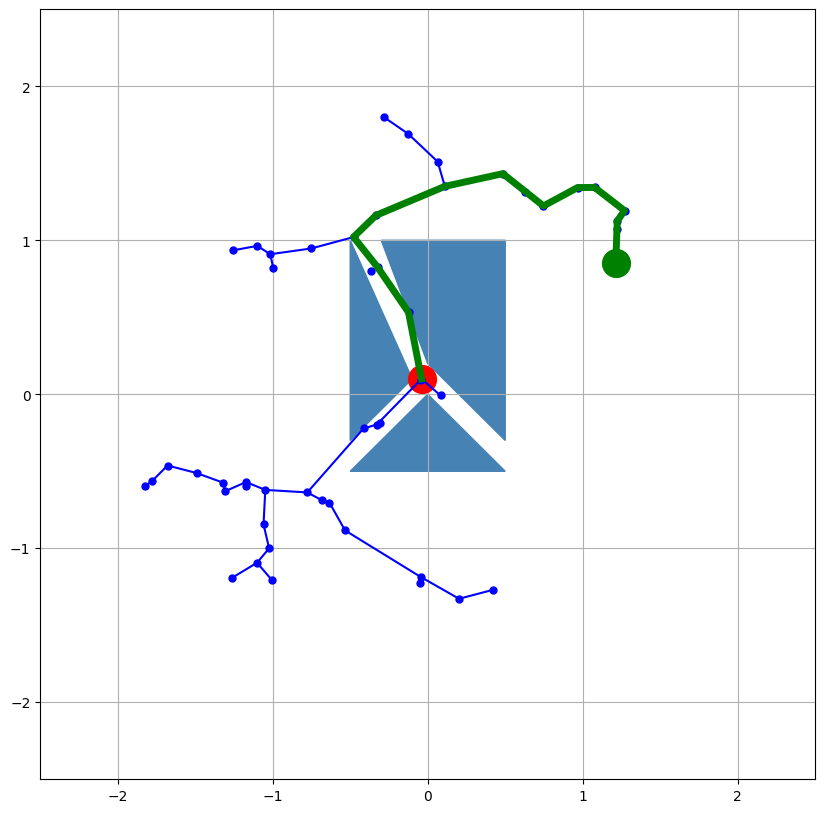

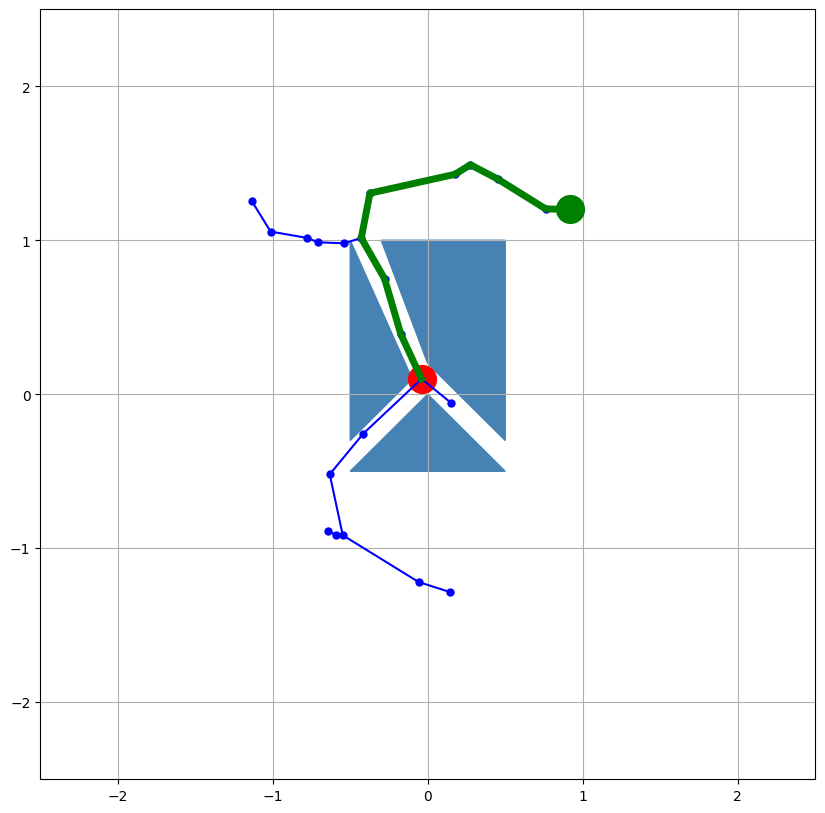

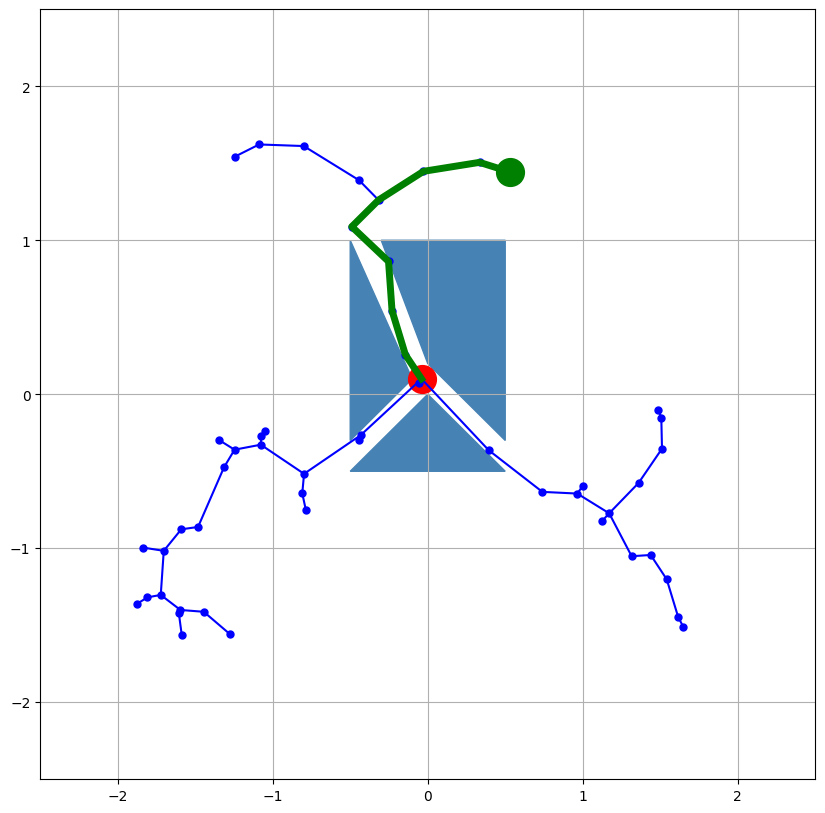

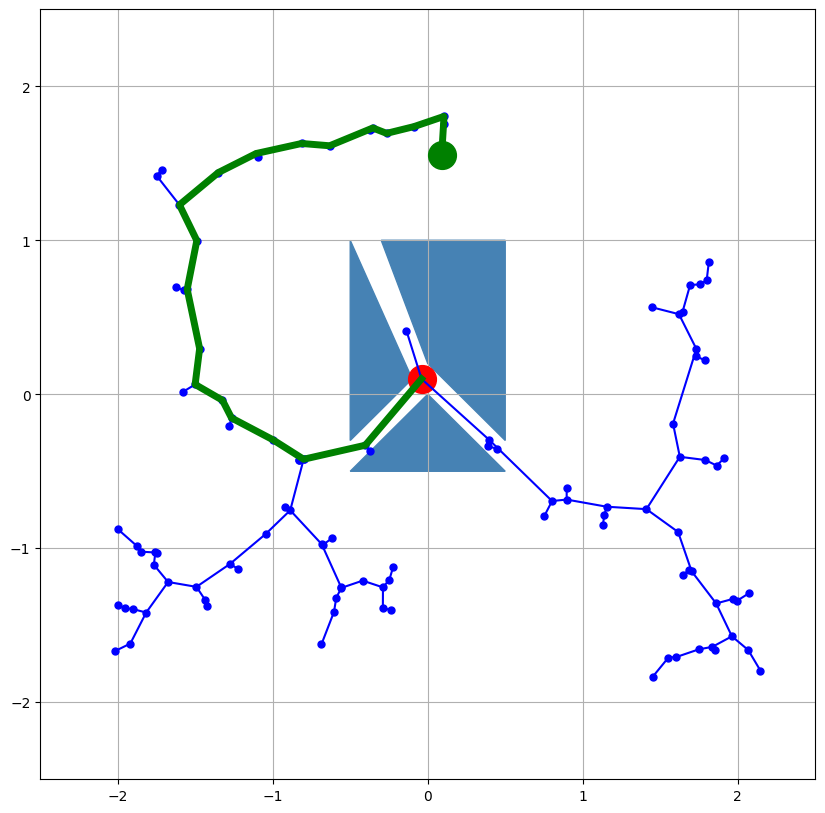

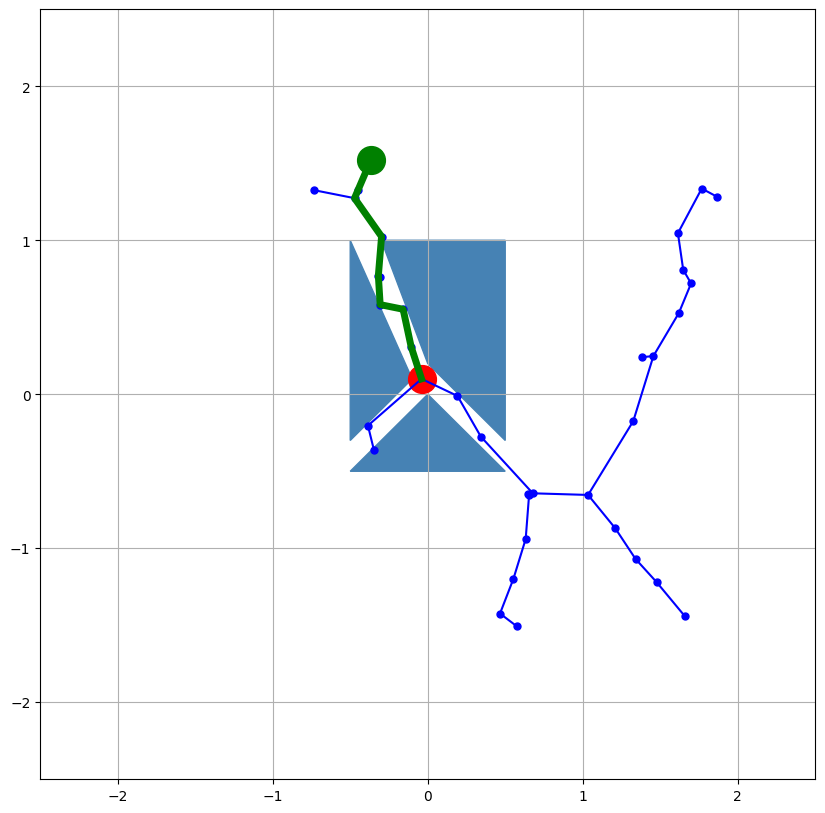

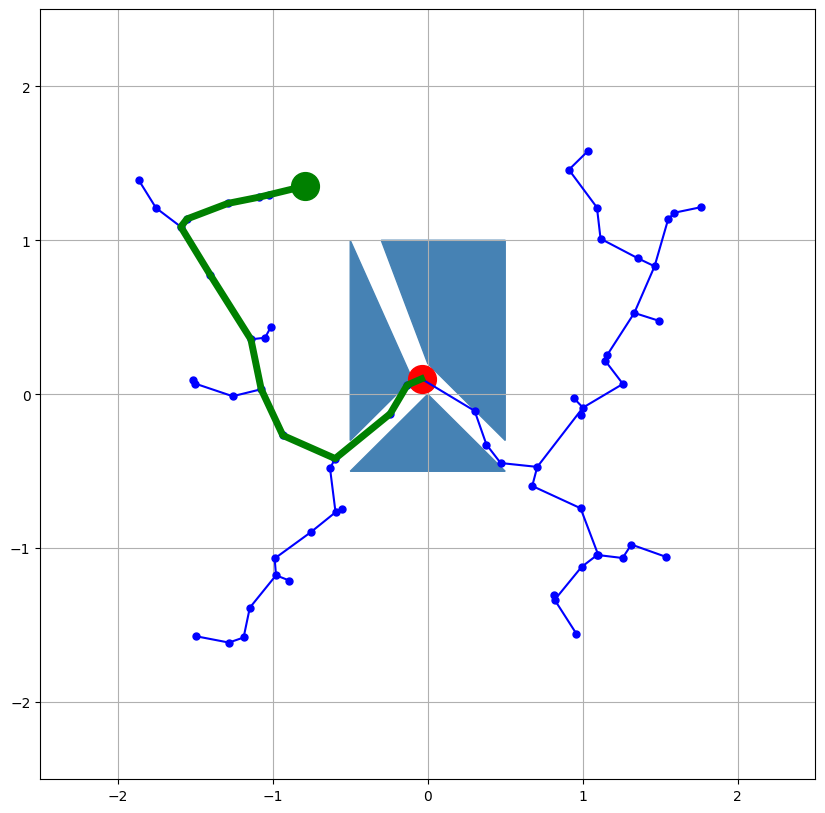

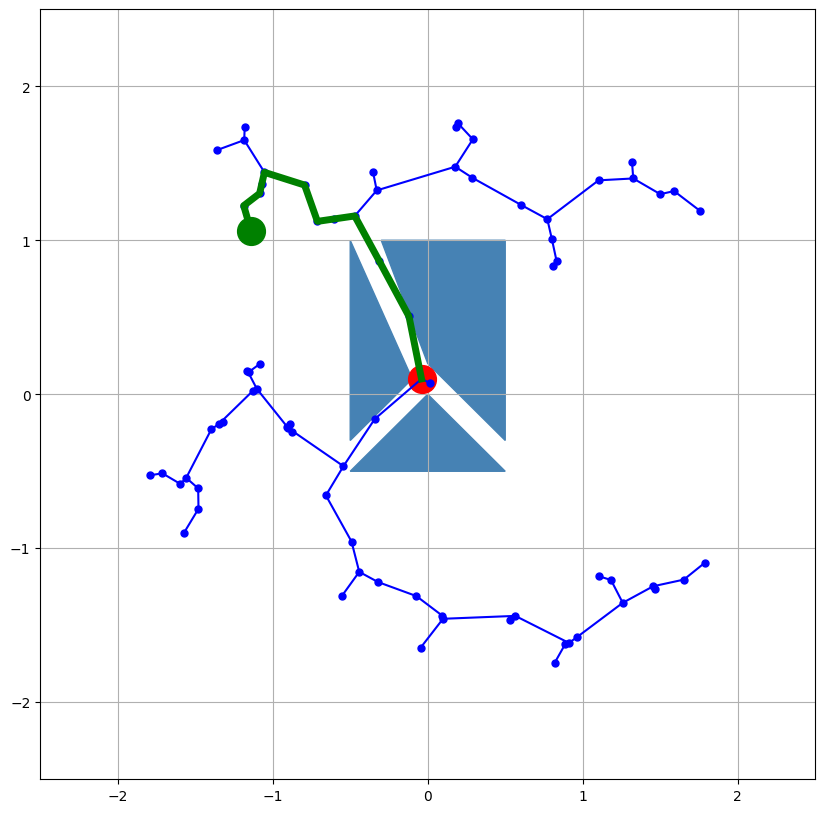

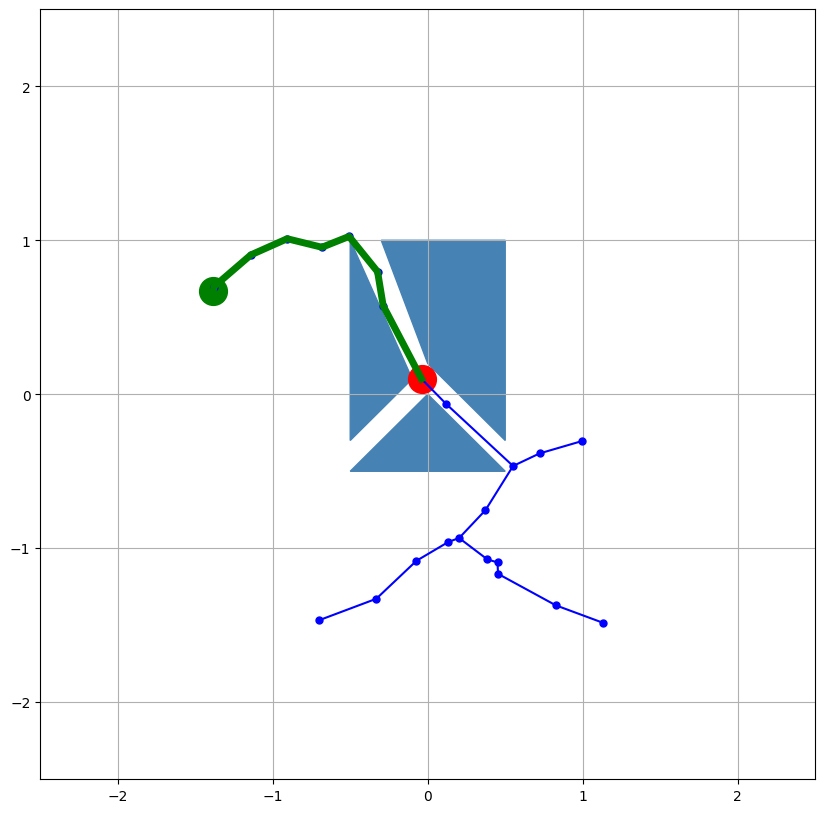

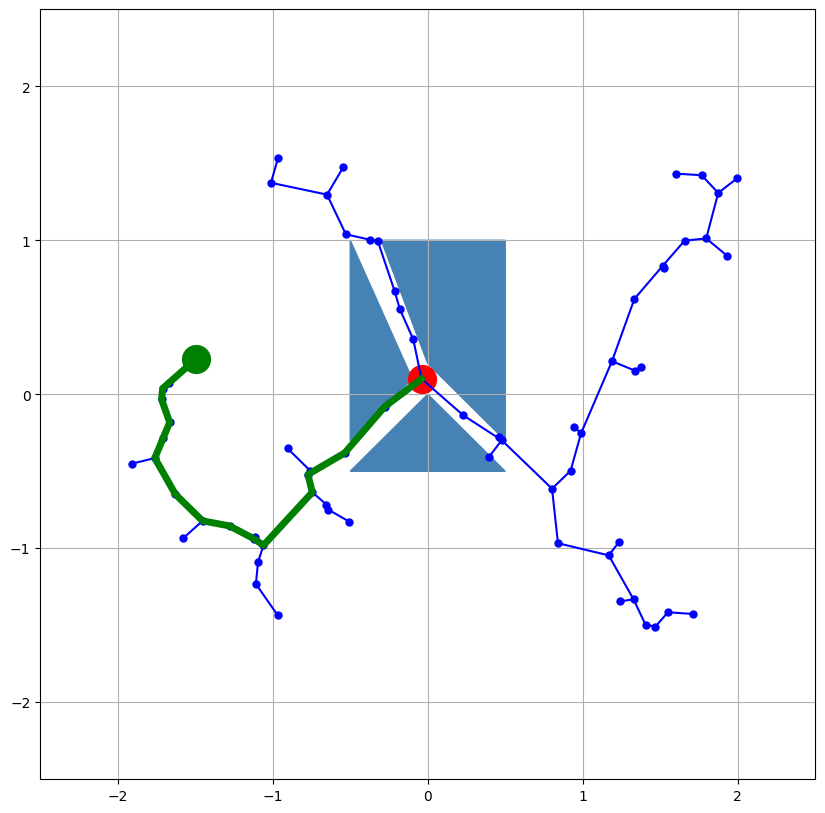

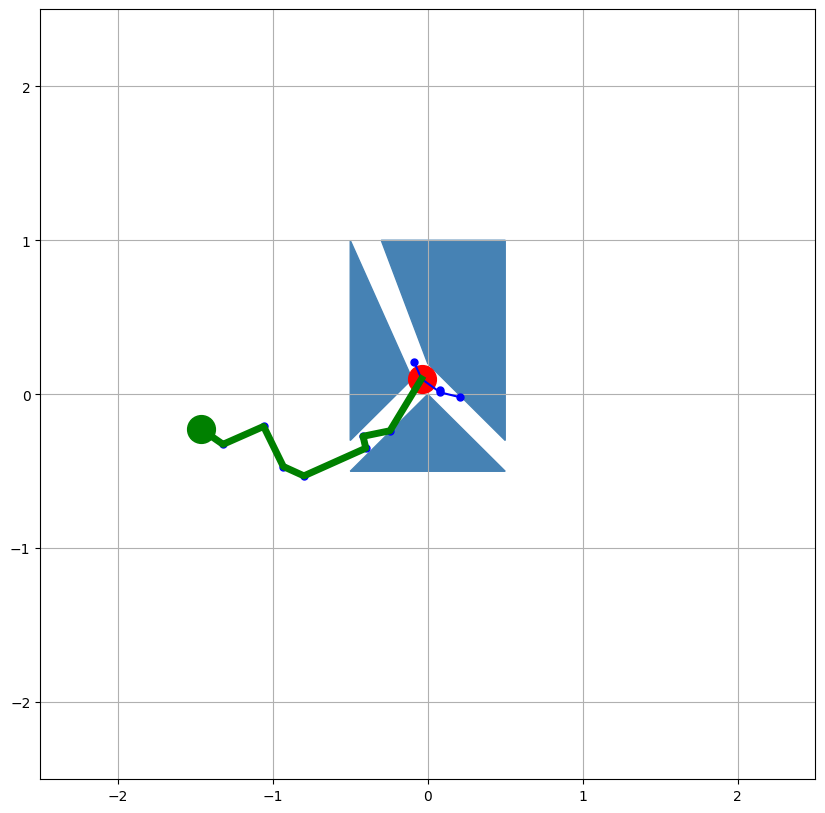

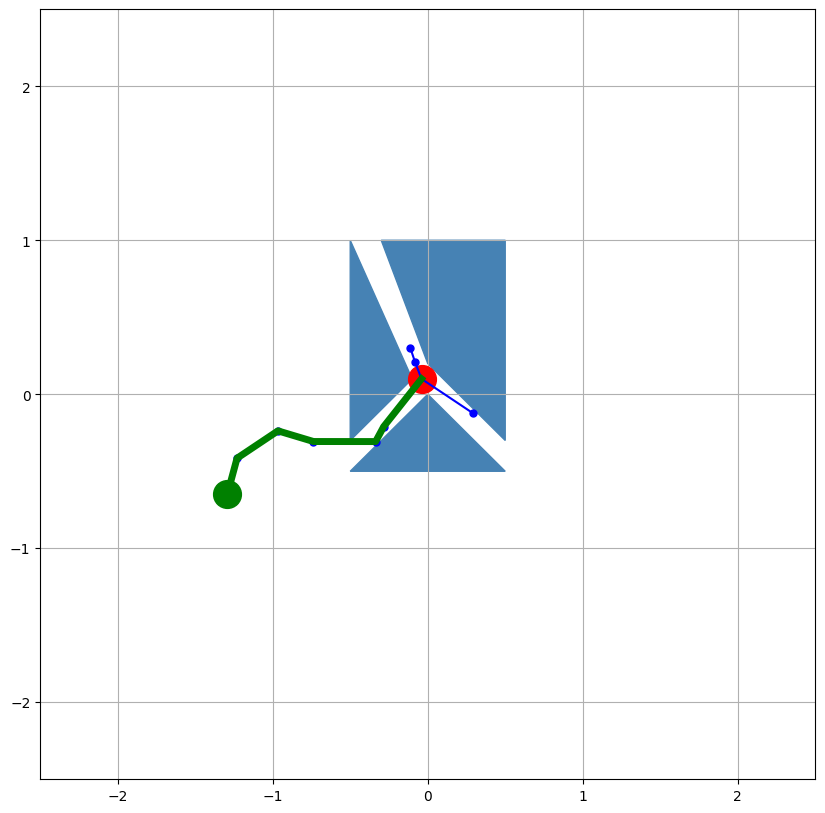

In [10]:
visualize_runs = 1
rotate_goal = 1 # Whether to rotate goal in circle around the start
maxiters  = 50000
nearGoal = False # This will be set to true if goal has been reached
minDistGoal = 0.25 # Convergence criterion: success when the tree reaches within 0.25 in distance from the goal.
d = 0.20 # Extension parameter: this controls how far the RRT extends in each step.
rrt_arr = [] # Array for keeping RRT from all runs
P_arr = [] # Array for keeping Paths from all runs
goal_arr = [] # Array for keeping Goals from all runs

runs = 20 # Number of runs per simulation
radius = math.sqrt((xy_goal[0] - xy_start[0]) ** 2 + (xy_goal[1] - xy_start[1]) ** 2) # radius of this circle
initial_angle = np.arctan2(xy_goal[1] - xy_start[1], xy_goal[0] - xy_start[0]) # Angle of initial goal
curr_goal = xy_goal # goal for current run

for run in range(runs):
    nearGoal = False

    if visualize_runs:
        draw_map(obstacles, 'steelblue')
        plt.plot(xy_start[0],xy_start[1],'ro', markersize=20)
        plt.plot(curr_goal[0], curr_goal[1], 'go', markersize=20)

    # Initialize RRT. The RRT will be represented as a 2 x N list of points.
    # So each column represents a vertex of the tree.
    rrt = []
    start_node = Node()
    start_node.p = xy_start
    start_node.i = 0
    start_node.iPrev = 0
    rrt.append(start_node)

    P = []

    # RRT algorithm
    start_time = time.time()
    iters = 0
    while not nearGoal and iters < maxiters:
        # Sample point
        rnd = random()
        # With probability 0.05, sample the goal. This promotes movement to the goal.
        if rnd < 0.05:
            xy = curr_goal
        else:
            # Sample (uniformly) from space (with probability 0.95). The space is defined
            # with the bounds world_bounds_x and world_bounds_y defined above.
            # So, the x coordinate should be sampled in the interval
            # world_bounds_x=2.5 and the y coordinate from world_bounds_y=2.5.
            xy = np.array([random()*5-2.5, random()*5-2.5]) # Should be a 2 x 1 vector
        # Check if sample is collision free
        collFree = isCollisionFreeVertex(obstacles, xy)
        # If it's not collision free, continue with loop
        if not collFree:
            iters += 1
            continue

        # If it is collision free, find closest point in existing tree.
        closest_node = closestNode(rrt, xy)

        # Extend tree towards xy from closest_vert. Use the extension parameter
        # d defined above as your step size. In other words, the Euclidean
        # distance between new_vert and closest_vert should be d.
        new_node = Node()
        new_node.p = closest_node.p + d * (xy - closest_node.p)
        new_node.i = len(rrt)
        new_node.iPrev = closest_node.i

        # Check if new vertice is in collision
        collFree = isCollisionFreeEdge(obstacles, closest_node.p, new_node.p)
        # If it's not collision free, continue with loop
        if not collFree:
            iters += 1
            continue

            # If it is collision free, add it to tree
        rrt.append(new_node)

        if visualize_runs:
            # plt.plot(xy[0], xy[1], 'ro', color='k')
            plt.plot(new_node.p[0], new_node.p[1], 'bo', markersize=5) # VERTICES
            plt.plot([closest_node.p[0], new_node.p[0]], [closest_node.p[1], new_node.p[1]], color='blue') # EDGES

        # Check if we have reached the goal
        if norm(np.array(curr_goal) - np.array(new_node.p)) < minDistGoal:
            # Add last, goal node
            goal_node = Node()
            goal_node.p = curr_goal
            goal_node.i = len(rrt)
            goal_node.iPrev = new_node.i
            if isCollisionFreeEdge(obstacles, new_node.p, goal_node.p):
                rrt.append(goal_node)
                P = [goal_node.p]
            else: P = []
            end_time = time.time()
            nearGoal = True
            print('Reached the goal after %.2f seconds:' % (end_time - start_time))

        iters += 1

    print('Number of iterations passed: %d / %d' %(iters, maxiters))
    print('RRT length: ', len(rrt))

    # Path construction from RRT:
    print('Constructing the path...')
    i = len(rrt) - 1
    while True:
        i = rrt[i].iPrev
        P.append(rrt[i].p)
        if i == 0:
            print('Reached RRT start node')
            break
    P = np.array(P)
    if visualize_runs:
        plt.plot( P[:,0], P[:,1], color='green', linewidth=5, label='RRT path' )

    rrt_arr.append(rrt)
    P_arr.append(P)
    goal_arr.append(np.copy(curr_goal))

    if rotate_goal:
        # Moving the goal in circle around the start
        angle = initial_angle + (2 * math.pi * (run + 1)) / runs # Angle for moving around start position in cirle
        curr_goal[0] = xy_start[0] + radius * math.cos(angle)
        curr_goal[1] = xy_start[1] + radius * math.sin(angle)

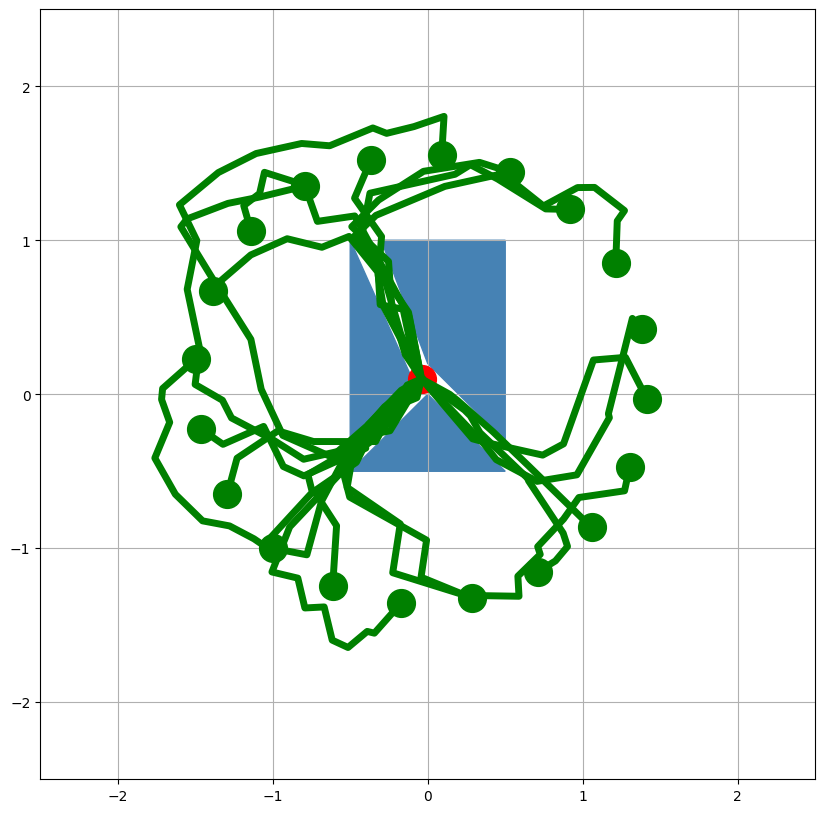

In [11]:
# Plotting all paths into one image
draw_map(obstacles, 'steelblue')
plt.plot(xy_start[0],xy_start[1],'ro', markersize=20)
for run in range(runs):
    curr_goal = goal_arr[run]
    P = P_arr[run]
    plt.plot(curr_goal[0], curr_goal[1], 'go', markersize=20)
    plt.plot( P[:,0], P[:,1], color='green', linewidth=5, label='RRT path' )
    

All tunnels found


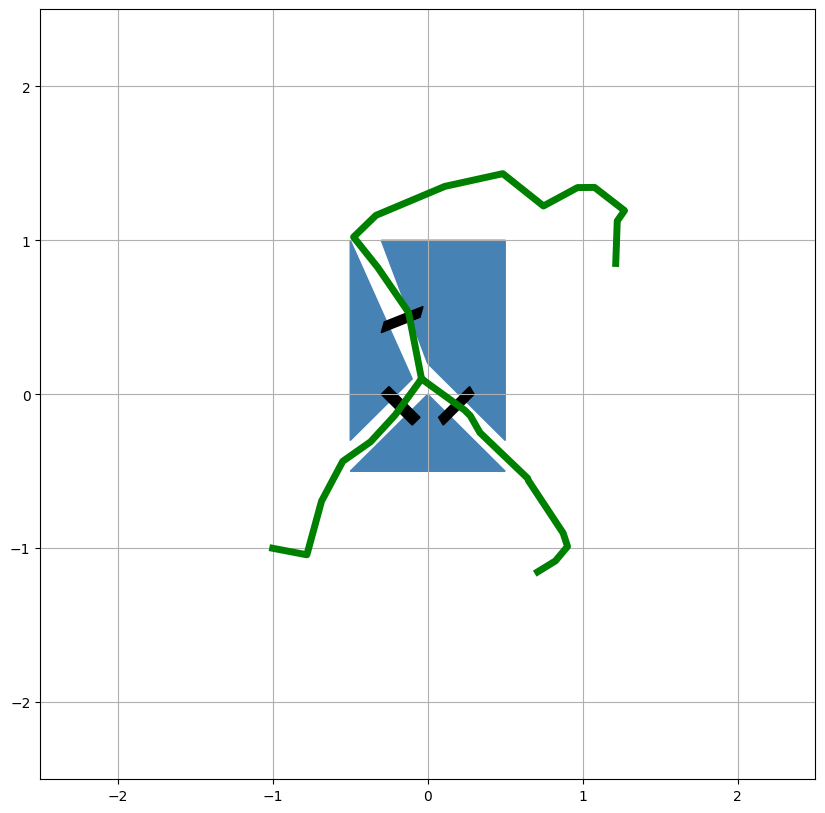

In [12]:
# Algorithm for checking if all tunnels were detected

# Creating new obstacles that close existing tunels
checks = [
            np.array([[-0.3, 0], [-0.1, -0.2], [-0.05, -0.15], [-0.25, 0.05]]),
            np.array([[0.1, -0.2], [0.3, 0], [0.27, 0.05], [0.07, -0.15]]),
            np.array([[-0.3, 0.4], [-0.05, 0.5], [-0.03, 0.57], [-0.28, 0.47]])
        ]
paths = []
checked = []

# Finding paths, that collide with new obstacles
for curr_path in P_arr:
    for i in range(len(checks)):
        for j in range(1, len(curr_path)):
            if i not in checked:
                if (not isCollisionFreeVertex([checks[i]], curr_path[j])) or (not isCollisionFreeEdge([checks[i]], curr_path[j], curr_path[j-1])):
                    checked.append(i)
                    paths.append(np.copy(curr_path))       

# when for each obstacle exists colliding path, all tunnels were found
if len(checked) == 3:
    print("All tunnels found")
else:
    print("Not all tunnels were found")

# printing one path for each found tunnel and new obstacles (black if tunnel was found, red otherwise)
draw_map(obstacles, 'steelblue')
for k in range(len(checks)):
        if k in checked:
            plt.gca().add_patch( Polygon(checks[k], color='black'))
        else:
            plt.gca().add_patch( Polygon(checks[k], color='red'))
for curr_path in paths:
    plt.plot( curr_path[:,0], curr_path[:,1], color='green', linewidth=5, label='RRT path' )